In [0]:
import numpy as np
import skimage as sm
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import glob
from skimage import io
import pandas as pd
%matplotlib inline
import extcolors
import random

In [0]:
def dominance(hist):
    red_dominance = np.sum(hist[0][1:18]) + np.sum(hist[0][329:359])#0
    orange_dominance = np.sum(hist[0][12:48])#1
    yellow_dominance = np.sum(hist[0][41:77])#2
    green_dominance = np.sum(hist[0][71:137])#4
    blue_dominance = np.sum(hist[0][137:250])#6
    purple_dominance = np.sum(hist[0][250:329])#8
    dominance = [red_dominance,orange_dominance,yellow_dominance,green_dominance,blue_dominance,purple_dominance]
    index = np.where(dominance == max(dominance))
    return index[0][0]

In [0]:
# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()
 
# Change thresholds
params.minThreshold = 0;
params.maxThreshold = 254;
 
# Filter by Area.
params.filterByArea = False

# Filter by Circularity
params.filterByCircularity = False

 
# Filter by Convexity
params.filterByConvexity = False

# Filter by Inertia
params.filterByInertia = False

In [0]:
#0 apple
#1 banana
#2 oranges
new_entry = {'file name': [],'fruit type':[], 'dominant_color':[],'rgbmean': [],'hsvmean':[], 'convexity':[], 'circularity':[], 'inertia ratio':[]}
features = pd.DataFrame(new_entry)

apples/


D:\Downloads\Anaconda3\lib\site-packages\skimage\measure\_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
D:\Downloads\Anaconda3\lib\site-packages\skimage\measure\_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


oranges/
bananas/


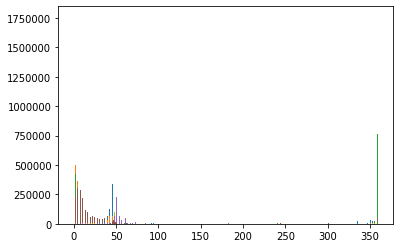

In [0]:
path = "fruits/"
fruit_folders = ["apples/", "oranges/", "bananas/"]
ind = 0
labels = ['red','orange','yellow']

for folder in fruit_folders:
    wdir = path + folder
    files = wdir+"*.jpg"
    ftype = labels[ind]
    ind +=1
    print(folder)
    for file in glob.glob(files):
        filename = file[-6:-4]
        fruit = cv2.imread(filename=file)
        gray = cv2.cvtColor(fruit, cv2.COLOR_BGR2GRAY)
        th, threshed = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10,10))
        morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)
        
        cnts = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
        cnt = sorted(cnts, key=cv2.contourArea)[-1]
        x,y,w,h = cv2.boundingRect(cnt)
        dst = fruit[y:y+h, x:x+w]
    
        save_file = wdir+"cropped/"+filename+"-cropped.jpg"
        cv2.imwrite(save_file,dst)
        
        fruit_c = cv2.imread(filename=save_file)
        fruit_rgb_mean = np.mean(fruit_c/256)
        hsv_fruit = cv2.cvtColor(fruit_c,cv2.COLOR_BGR2HSV)
        hist = np.histogram(a=hsv_fruit[:, :, 0], bins=360)
        
        save_hist = wdir+"cropped/"+filename+"-histogram.jpg"
        histimg = plt.bar(x=np.arange(360), height=hist[0])
        plt.savefig(save_hist)
        
        dominant_color = dominance(hist)
        hsv_mean = np.mean(hsv_fruit[:, :, 0])
        
        ret,thresh = cv2.threshold(gray,240,255,cv2.THRESH_BINARY_INV)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4,4))
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
      # Set up the detector with default parameters.
        detector = cv2.SimpleBlobDetector_create(params)
      # Detect blobs.
        keypoints = detector.detect(thresh)
        label, N = sm.measure.label(thresh, background=0, return_num=True)
        
        if N!=1:
            while N != 1:
                thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
                detector = cv2.SimpleBlobDetector_create(params)
                keypoints = detector.detect(thresh)
                label, N = sm.measure.label(thresh, background=0, return_num=True)
            #print(filename,N)
            binary = wdir+"cropped/"+filename+"-binary.jpg"
            cv2.imwrite(binary,thresh)
            reg = sm.measure.regionprops(label,thresh)
            area = reg[0].area
            conv_area = reg[0].convex_area
            perimeter = reg[0].perimeter
            inertia_a = reg[0].inertia_tensor_eigvals[0]
            inertia_b = reg[0].inertia_tensor_eigvals[1]
    
            convexity = area / conv_area
            circularity = (4* np.pi * area) / (perimeter**2)
            inertia = inertia_b/inertia_a
            #print(filename,' RGB MEAN:',fruit_rgb_mean,'; N:',N,'; Convexity:', convexity,'; Circularity:',circularity,'; Inertia:',inertia)
            new_entry = {'file name': filename,'fruit type':ftype, 'dominant_color':dominant_color,'rgbmean':fruit_rgb_mean ,'hsvmean':hsv_mean, 'convexity':convexity, 'circularity':circularity, 'inertia ratio':inertia}
            features = features.append(new_entry, ignore_index=True)
        
            continue
        
        #print(N)
        binary = wdir+"cropped/"+filename+"-binary.jpg"
        cv2.imwrite(binary,thresh)
    
        reg = sm.measure.regionprops(label,thresh)
        area = reg[0].area
        conv_area = reg[0].convex_area
        perimeter = reg[0].perimeter
        inertia_a = reg[0].inertia_tensor_eigvals[0]
        inertia_b = reg[0].inertia_tensor_eigvals[1]
    
        convexity = area / conv_area
        circularity = (4* np.pi * area) / (perimeter**2)
        inertia = inertia_b/inertia_a        
        new_entry = {'file name': filename,'fruit type':ftype, 'dominant_color':dominant_color,'rgbmean': fruit_rgb_mean,'hsvmean':hsv_mean, 'convexity':convexity, 'circularity':circularity, 'inertia ratio':inertia}
        features = features.append(new_entry, ignore_index=True)

In [0]:
features

,file name,fruit type,dominant_color,rgbmean,hsvmean,convexity,circularity,inertia ratio
0,01,red,0.0,0.515804,105.550144,0.925760,0.512439,0.664910
1,02,red,0.0,0.595774,15.526212,0.999024,0.892545,0.885877
2,03,red,0.0,0.529208,49.530879,0.965941,0.633915,0.726095
3,08,red,0.0,0.497882,71.614742,0.991004,0.878732,0.827307
4,09,red,0.0,0.489888,99.081343,0.962301,0.749591,0.826559
5,15,red,0.0,0.627684,8.920236,0.985413,0.826993,0.907376
6,16,red,1.0,0.616134,14.547421,0.976841,0.789151,0.965360
7,19,red,0.0,0.585084,64.443734,0.907978,0.629531,0.588133
8,22,red,0.0,0.603666,81.045480,0.854527,0.409290,0.550018
9,25,red,0.0,0.617304,29.821999,0.935736,0.729294,0.725295


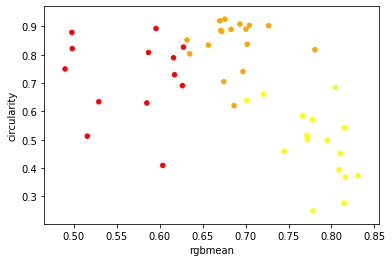

In [0]:
features.plot(x ='rgbmean', y='circularity', kind = 'scatter',  c=features['fruit type'])

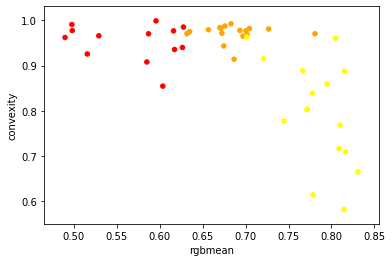

In [0]:
features.plot(x ='rgbmean', y='convexity', kind = 'scatter',  c=features['fruit type'])

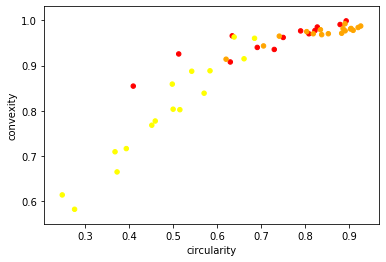

In [0]:
features.plot(x ='circularity', y='convexity', kind = 'scatter',  c=features['fruit type'])

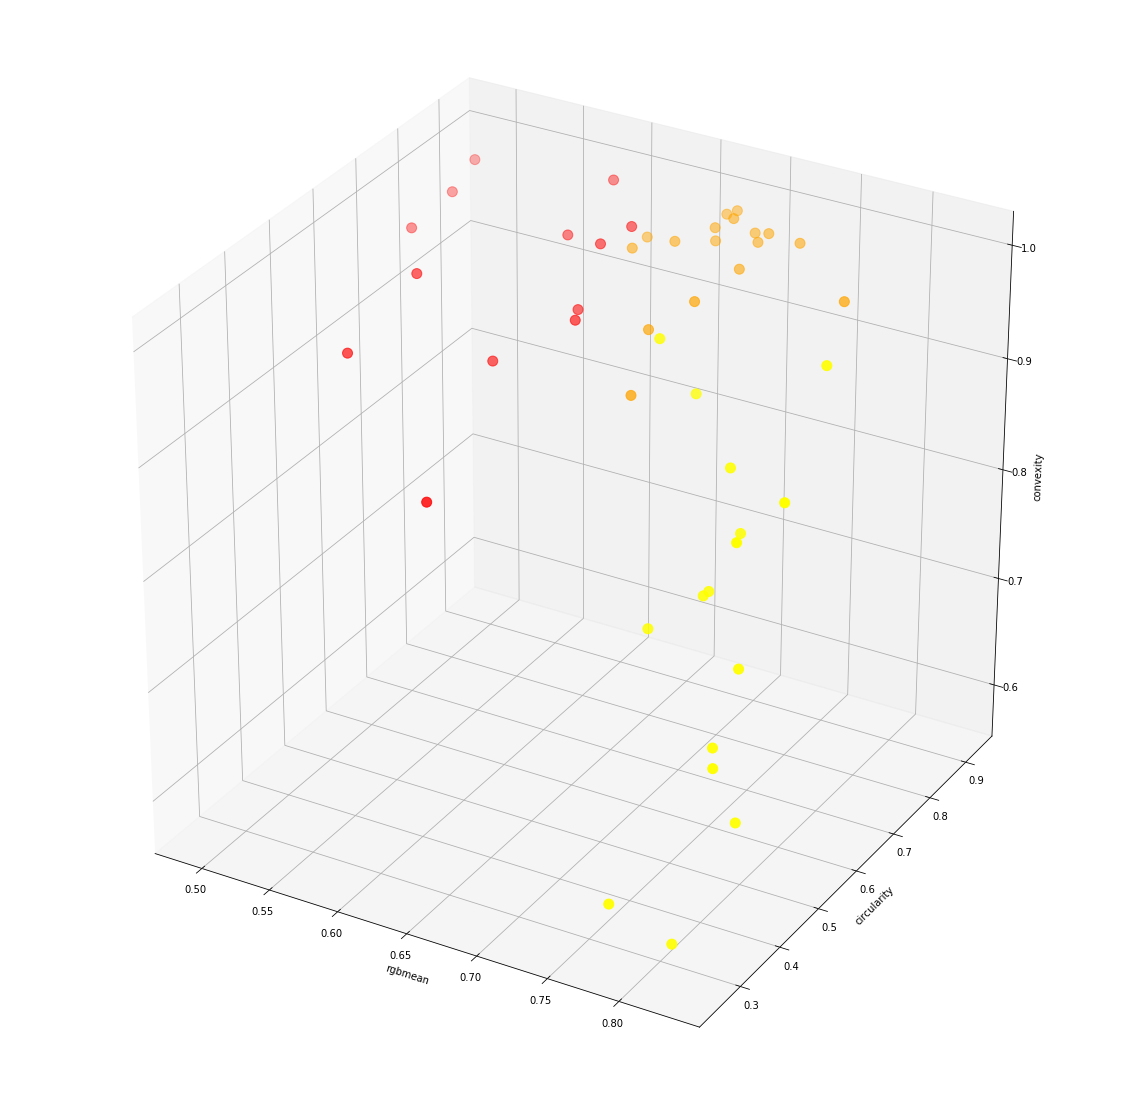

In [0]:
from mpl_toolkits.mplot3d import Axes3D
threeD = plt.figure(figsize = [20,20]).gca(projection='3d')
threeD.scatter(features['rgbmean'], features['circularity'], features['convexity'],c=features['fruit type'], s =100)
threeD.set_xlabel('rgbmean')
threeD.set_ylabel('circularity')
threeD.set_zlabel('convexity')
plt.show()

# Mine

In [0]:
def step_func(aval):
    if aval >= 0:
        return 1
    else:
        return -1

In [0]:
ay = features[features['fruit type']!= 'orange']
#weights = np.random.uniform(0,1,2)
weights = np.array([0,0,0])
print(weights)
for epoch in range(100000):
    for i in (ay.index):
        if ay['fruit type'][i] == 'red':
            d = 1.0
        elif ay['fruit type'][i] == 'yellow':
            d = -1.0
        n = 0.1
        x1 =ay['rgbmean'][i]
        x2 = ay['circularity'][i]
        a = x1*weights[1] + x2*weights[2] + 1*weights[0]
        z = step_func(a)
        weights[0] += n*(d-z)*1
        weights[1] += n*(d-z)*x1
        weights[2] += n*(d-z)*x2
print(weights)
A = weights[1]
B = weights[2]
C = -weights[0]
slope = -B/A
inter = -C/B

[0 0 0]
[0 0 0]


D:\Downloads\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars
D:\Downloads\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in long_scalars


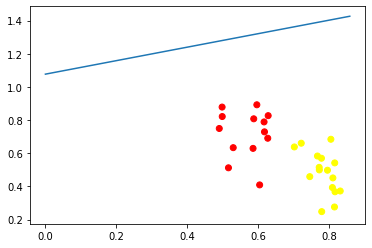

In [0]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x =ay['rgbmean'], y=ay['circularity'],  c=ay['fruit type'])

x_min, x_max = ax1.get_xlim()
ax1.plot([0, x_max], [inter, x_max*slope+inter])

# Kenneth

In [0]:
def g(a):
    if a>=0: return 1
    else: return -1


In [0]:
def two_classes(x1,x2,x3,x4):    
    vals = np.zeros(len(x1))
    vals[vals==0] = 1

    vals1 = np.zeros(len(x3))
    vals1[vals1==0] = -1

    X1 = list(zip(vals,x1, x2))
    X2 = list(zip(vals,x3, x4))
    X = X1 + X2
    X = np.array(X)
    X = X.astype(float)

    D1 = np.zeros(len(X1))
    D1[D1==0] = 1 
    D2 = np.zeros(len(X2))
    D2[D2==0] = -1
    D = np.append(D1,D2)

    return X,D

In [0]:
def perceptron(X,D):
    w = np.zeros(3)
    w[0],w[1],w[2] = random.random(), random.random(),random.random()

    eta = random.random()

    epochs = 10000 #can be longer
    for t in range(epochs):
        for i,x in enumerate(X):
            a = np.dot(x.T,w)
            z = g(a)
            delta_w = eta*(D[i] - z)*x
            w += delta_w
    return w

In [0]:
def line_parameters(w):
    A, B, C = w[1], w[2], -w[0]
    m = -A/B
    b = C/B
    return m, b

In [0]:
apple = features[features['fruit type'] == 'red']
banana = features[features['fruit type'] == 'yellow']
orange = features[features['fruit type'] == 'orange']

#  RGB vs Circularity

In [0]:
X1,D1 = two_classes(banana['rgbmean'], banana['circularity'], apple['rgbmean'], apple['circularity'])
w1 = perceptron(X1,D1)
m1,b1 = line_parameters(w1)

X2,D2 = two_classes(banana['rgbmean'], banana['circularity'], orange['rgbmean'], orange['circularity'])
w2 = perceptron(X2,D2)
m2,b2 = line_parameters(w2)

X3,D3 = two_classes(apple['rgbmean'], apple['circularity'], orange['rgbmean'], orange['circularity'])
w3 = perceptron(X3,D3)
m3,b3 = line_parameters(w3)

print(m1,b1)
print(m2,b2)
print(m3,b3)

2.442326206698253 -1.0748217803174953
1.2845686675397172 -0.2627399048039989
33.441048987662114 -20.273627686573118


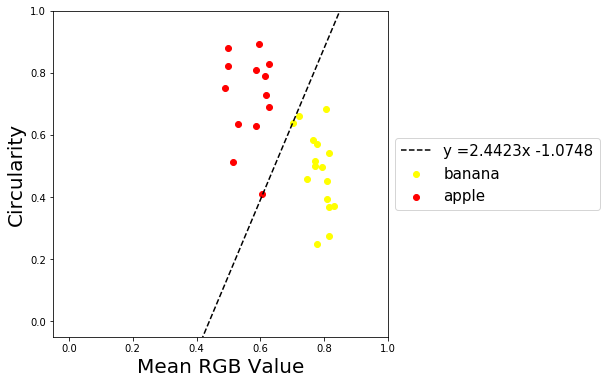

In [0]:
plt.figure(figsize=[6,6])
xvals = np.linspace(-1,1,100)
yvals1 = b1 + m1*xvals
plt.plot(xvals, yvals1, color='black', linestyle='--', label = 'y =' + str(round(m1,4)) +'x ' + str(round(b1,4)))
plt.scatter(banana['rgbmean'], banana['circularity'], color='yellow', label='banana')
plt.scatter(apple['rgbmean'], apple['circularity'], color='red', label='apple')
plt.xlim(-0.05,1)
plt.ylim(-0.050,1)
plt.xlabel('Mean RGB Value', fontsize=20)
plt.ylabel('Circularity', fontsize=20)
plt.legend(fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5))

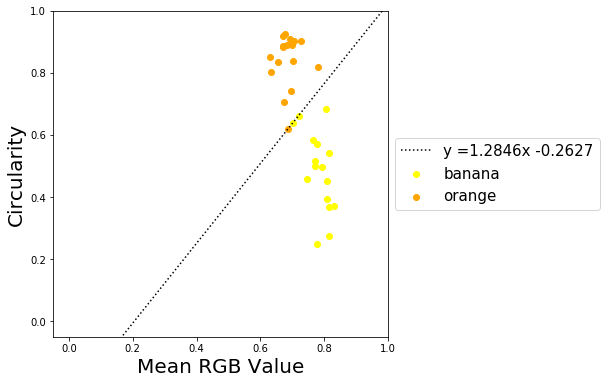

In [0]:
plt.figure(figsize=[6,6])
xvals = np.linspace(-1,1,100)
yvals2 = b2 + m2*xvals
plt.plot(xvals, yvals2, color='black', linestyle='dotted', label = 'y =' + str(round(m2,4)) +'x ' + str(round(b2,4)))
plt.scatter(banana['rgbmean'], banana['circularity'], color='yellow', label='banana')
plt.scatter(orange['rgbmean'], orange['circularity'], color='orange', label='orange')
plt.xlim(-0.05,1)
plt.ylim(-0.050,1)
plt.xlabel('Mean RGB Value', fontsize=20)
plt.ylabel('Circularity', fontsize=20)
plt.legend(fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5))

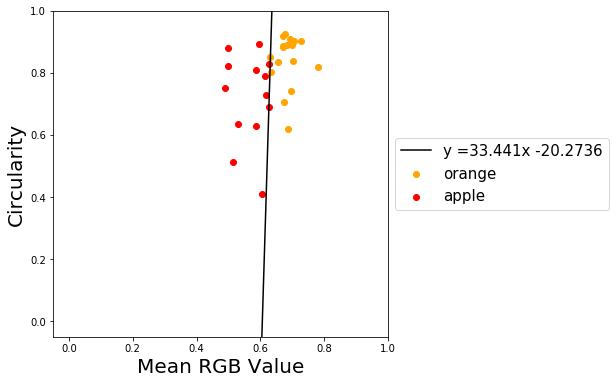

In [0]:
plt.figure(figsize=[6,6])
xvals = np.linspace(-1,1,100)
yvals3 = b3 + m3*xvals
plt.plot(xvals, yvals3, color='black', label = 'y =' + str(round(m3,4)) +'x ' + str(round(b3,4)))
plt.scatter(orange['rgbmean'], orange['circularity'], color='orange', label='orange')
plt.scatter(apple['rgbmean'], apple['circularity'], color='red', label='apple')
plt.xlim(-0.05,1)
plt.ylim(-0.050,1)
plt.xlabel('Mean RGB Value', fontsize=20)
plt.ylabel('Circularity', fontsize=20)
plt.legend(fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5))

# RGB vs Convexity

In [0]:
X1,D1 = two_classes(banana['rgbmean'], banana['convexity'], apple['rgbmean'], apple['convexity'])
w1 = perceptron(X1,D1)
m1,b1 = line_parameters(w1)

X2,D2 = two_classes(banana['rgbmean'], banana['convexity'], orange['rgbmean'], orange['convexity'])
w2 = perceptron(X2,D2)
m2,b2 = line_parameters(w2)

X3,D3 = two_classes(apple['rgbmean'], apple['convexity'], orange['rgbmean'], orange['convexity'])
w3 = perceptron(X3,D3)
m3,b3 = line_parameters(w3)

print(m1,b1)
print(m2,b2)
print(m3,b3)

1.2770060228270133 0.0683638114948092
0.6098943109456404 0.49351957316688827
3.0479742016675 -0.9266834535142467


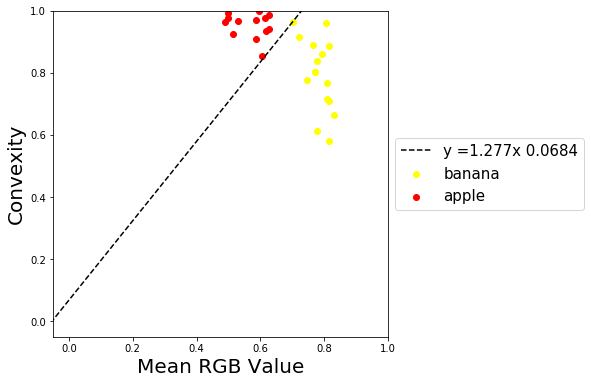

In [0]:
plt.figure(figsize=[6,6])
xvals = np.linspace(-1,1,100)
yvals1 = b1 + m1*xvals
plt.plot(xvals, yvals1, color='black', linestyle='--', label = 'y =' + str(round(m1,4)) +'x ' + str(round(b1,4)))
plt.scatter(banana['rgbmean'], banana['convexity'], color='yellow', label='banana')
plt.scatter(apple['rgbmean'], apple['convexity'], color='red', label='apple')
plt.xlim(-0.05,1)
plt.ylim(-0.050,1)
plt.xlabel('Mean RGB Value', fontsize=20)
plt.ylabel('Convexity', fontsize=20)
plt.legend(fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5))

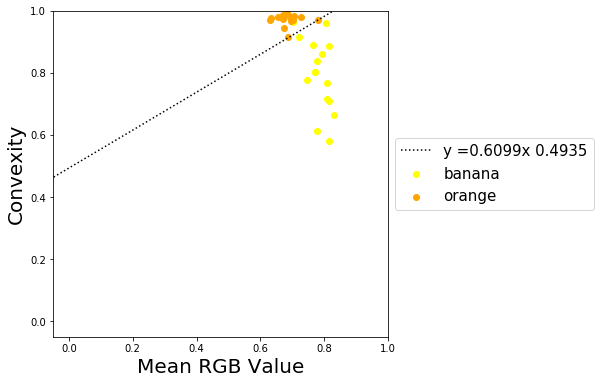

In [0]:
plt.figure(figsize=[6,6])
xvals = np.linspace(-1,1,100)
yvals2 = b2 + m2*xvals
plt.plot(xvals, yvals2, color='black', linestyle='dotted', label = 'y =' + str(round(m2,4)) +'x ' + str(round(b2,4)))
plt.scatter(banana['rgbmean'], banana['convexity'], color='yellow', label='banana')
plt.scatter(orange['rgbmean'], orange['convexity'], color='orange', label='orange')
plt.xlim(-0.05,1)
plt.ylim(-0.050,1)
plt.xlabel('Mean RGB Value', fontsize=20)
plt.ylabel('Convexity', fontsize=20)
plt.legend(fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5))

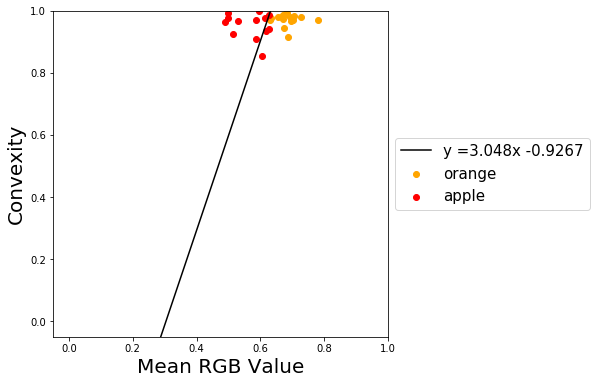

In [0]:
plt.figure(figsize=[6,6])
xvals = np.linspace(-1,1,100)
yvals3 = b3 + m3*xvals
plt.plot(xvals, yvals3, color='black', label = 'y =' + str(round(m3,4)) +'x ' + str(round(b3,4)))
plt.scatter(orange['rgbmean'], orange['convexity'], color='orange', label='orange')
plt.scatter(apple['rgbmean'], apple['convexity'], color='red', label='apple')
plt.xlim(-0.05,1)
plt.ylim(-0.050,1)
plt.xlabel('Mean RGB Value', fontsize=20)
plt.ylabel('Convexity', fontsize=20)
plt.legend(fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5))

# Circularity vs Convexity

In [0]:
X1,D1 = two_classes(banana['circularity'], banana['convexity'], apple['circularity'], apple['convexity'])
w1 = perceptron(X1,D1)
m1,b1 = line_parameters(w1)

X2,D2 = two_classes(banana['circularity'], banana['convexity'], orange['circularity'], orange['convexity'])
w2 = perceptron(X2,D2)
m2,b2 = line_parameters(w2)

X3,D3 = two_classes(apple['circularity'], apple['convexity'], orange['circularity'], orange['convexity'])
w3 = perceptron(X3,D3)
m3,b3 = line_parameters(w3)

print(m1,b1)
print(m2,b2)
print(m3,b3)

0.2015321965664235 0.7490498283717489
-0.8686807312191139 1.2466350725074142
0.33967945328139054 0.748585526493625


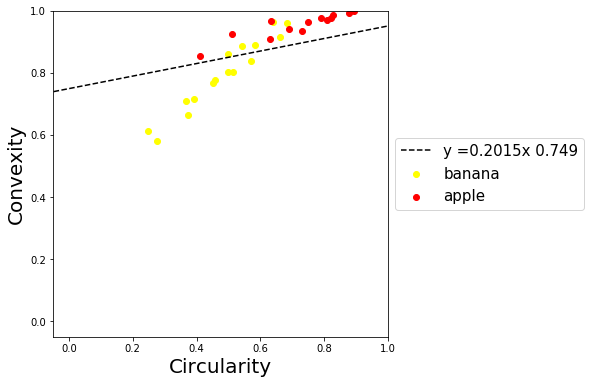

In [0]:
plt.figure(figsize=[6,6])
xvals = np.linspace(-1,1,100)
yvals1 = b1 + m1*xvals
plt.plot(xvals, yvals1, color='black', linestyle='--', label = 'y =' + str(round(m1,4)) +'x ' + str(round(b1,4)))
plt.scatter(banana['circularity'], banana['convexity'], color='yellow', label='banana')
plt.scatter(apple['circularity'], apple['convexity'], color='red', label='apple')
plt.xlim(-0.05,1)
plt.ylim(-0.050,1)
plt.xlabel('Circularity', fontsize=20)
plt.ylabel('Convexity', fontsize=20)
plt.legend(fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5))

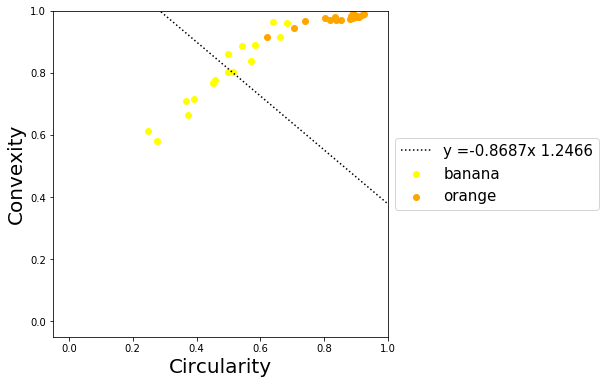

In [0]:
plt.figure(figsize=[6,6])
xvals = np.linspace(-1,1,100)
yvals2 = b2 + m2*xvals
plt.plot(xvals, yvals2, color='black', linestyle='dotted', label = 'y =' + str(round(m2,4)) +'x ' + str(round(b2,4)))
plt.scatter(banana['circularity'], banana['convexity'], color='yellow', label='banana')
plt.scatter(orange['circularity'], orange['convexity'], color='orange', label='orange')
plt.xlim(-0.05,1)
plt.ylim(-0.050,1)
plt.xlabel('Circularity', fontsize=20)
plt.ylabel('Convexity', fontsize=20)
plt.legend(fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5))

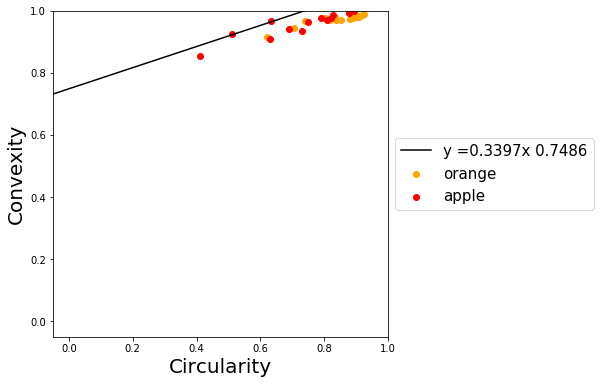

In [0]:
plt.figure(figsize=[6,6])
xvals = np.linspace(-1,1,100)
yvals3 = b3 + m3*xvals
plt.plot(xvals, yvals3, color='black', label = 'y =' + str(round(m3,4)) +'x ' + str(round(b3,4)))
plt.scatter(orange['circularity'], orange['convexity'], color='orange', label='orange')
plt.scatter(apple['circularity'], apple['convexity'], color='red', label='apple')
plt.xlim(-0.05,1)
plt.ylim(-0.050,1)
plt.xlabel('Circularity', fontsize=20)
plt.ylabel('Convexity', fontsize=20)
plt.legend(fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5))